### What this program does:
- Exploratory data analysis;
- define the threshold values to cut off nodes in both gene and drug sets;
- generate binarized interaction matrices for the drug-gene bipartite graph according to a specific sparsity ratio;
- in an output matrix, each row indexes a gene and each column indexes a drug type (compound), with the value of (i,j)-th entry indicating the presence/absence of edge between the i-th gene and j-th drug type

In [120]:
import pandas as pd

In [121]:
def create_interaction_matrix(df, min_gene_count=0, min_drug_count=0):
    '''
    This function generates the binarized drug-gene interation matrices
    :param df: DataFrame of the raw data
    :param min_gene_count: threshold value for degree of nodes in gene set
    :param min_drug_count: threshold for degree of nodes in drug set
    :return: the interaction matrix
    '''

    # Filter rows based on the count of "gene_claim_name" and "drug_claim_name"
    gene_counts = df['gene_claim_name'].value_counts()
    drug_counts = df['drug_claim_name'].value_counts()

    # Create boolean masks for filtering
    gene_mask = df['gene_claim_name'].map(gene_counts) >= min_gene_count
    drug_mask = df['drug_claim_name'].map(drug_counts) >= min_drug_count

    # Apply the masks to filter the DataFrame
    df_filtered = df[gene_mask & drug_mask]

    # Drop rows where 'drug_claim_name' or 'gene_claim_name' is NA
    df_filtered = df_filtered.dropna(subset=['drug_claim_name', 'gene_claim_name'])

    # Create a pivot table to get the interaction matrix
    interaction_matrix = df_filtered.pivot_table(
        values= 'interaction_group_score',
        index='gene_claim_name',
        columns='drug_claim_name',
        fill_value=0  # Set fill_value to 0 for cells with no interaction
    )

    binarized_interaction_matrix = (interaction_matrix > 0).astype(int)

    return binarized_interaction_matrix

In [122]:
def count_num_edges(interaction_matrix):
    '''
    This function counts the number of edges in the drug-gene interaction network.
    :param interaction_matrix: DataFrame that represents the drug-gene interaction matrix
    :return: number of edges in the network
    '''

    num_edges = (interaction_matrix > 0).sum().sum()

    return num_edges

In [123]:
def calc_gene_drug_ratio(interaction_matrix):
    '''
    This function calculates the gene-drug ratio of a drug-gene interaction network.
    :param interaction_matrix: DataFrame that represents the drug-gene interaction matrix
    :return: gene drug ratio of the network
    '''
    gene_cnt = len(interaction_matrix)
    drug_cnt = len(interaction_matrix.columns)
    gene_drug_ratio = gene_cnt/drug_cnt
    return gene_drug_ratio

In [124]:
def calc_sparsity_ratio(interaction_matrix):
    '''
    This function calculates the sparsity ratio of a drug-gene interaction network.
    :param interaction_matrix: DataFrame that represents the drug-gene interaction matrix
    :return: sparsity ratio of the network
    '''
    gene_cnt = len(interaction_matrix)
    drug_cnt = len(interaction_matrix.columns)
    num_edges = count_num_edges(interaction_matrix)
    sparsity_ratio = num_edges/(gene_cnt*drug_cnt)
    return sparsity_ratio

In [125]:
def show_info(interaction_matrix):
    '''
    This function outputs the following information of an interaction matrix:
    - number of genes and drug types
    - number of edges
    - sparsity ratio
    - gene-drug ratio
    :param interaction_matrix: DataFrame that represents the drug-gene interaction matrix
    '''
    gene_cnt = len(interaction_matrix)
    drug_cnt = len(interaction_matrix.columns)
    edge_cnt = count_num_edges(interaction_matrix)
    print("----------------------------------")
    print("Number of genes: ", gene_cnt)
    print("Number of drug types: ", drug_cnt)
    print("Number of edges: ", edge_cnt)
    print("Sparsity ratio: ", calc_sparsity_ratio(interaction_matrix))
    print("Gene-drug ratio: ", calc_gene_drug_ratio(interaction_matrix))
    print("----------------------------------\n")

In [126]:
def count_degrees(interaction_matrix):
    '''
    This function counts the degree for gene nodes and drug nodes.
    :param interaction_matrix: DataFrame that represents the drug-gene interaction matrix
    :return: a list for degree of gene nodes & a list for degree of drug nodes
    '''
    gene_degree_cnt = (interaction_matrix != 0).sum(axis=1).tolist()
    drug_degree_cnt = (interaction_matrix != 0).sum().tolist()
    return gene_degree_cnt, drug_degree_cnt

In [127]:
file_path = "../data/interactions.tsv"


# Read data from TSV file into a pandas DataFrame
df = pd.read_csv(file_path, sep='\t')
candidate_matrices = []

## Explore the relationship between gene-drug ratio and sparsity ratio


In [128]:
for gene_threshold in range (5, 51, 1):
    for drug_threshold in range (2,11,1):
        interaction_matrix = create_interaction_matrix(df, min_gene_count=gene_threshold, min_drug_count=drug_threshold) # the interaction matrix
        #print("min_gene_count: ", gene_threshold, end=", ")
        #print("min_drug_cnt: ", drug_threshold)
        sparsity_ratio = calc_sparsity_ratio(interaction_matrix) # sparsity ratio
        gene_drug_ratio = calc_gene_drug_ratio(interaction_matrix) # gene-drug ratio
        # Store the matrices along with their parameters in a separate list
        matrix_data = {
            "gene_threshold": gene_threshold,
            "drug_threshold": drug_threshold,
            "interaction_matrix": interaction_matrix,
            "sparsity_ratio": sparsity_ratio,
            "gene_drug_ratio": gene_drug_ratio
        }
        candidate_matrices.append(matrix_data)
        #show_info(interaction_matrix)

## Explore the relationship between gene-drug ratio and sparsity ratio

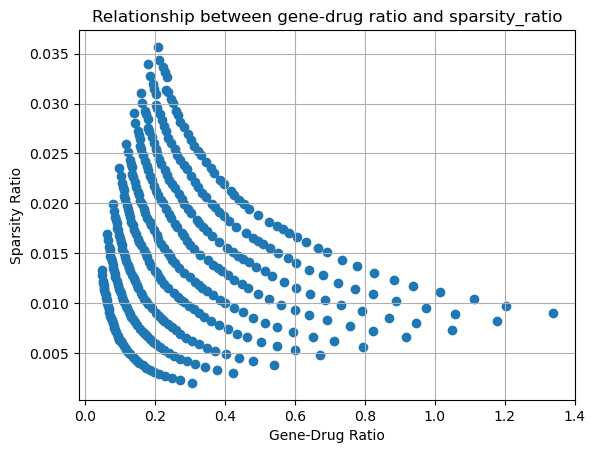

In [129]:
import matplotlib.pyplot as plt

sparsity_ratio_li = [matrix["sparsity_ratio"] for matrix in candidate_matrices]
gene_drug_ratio_li = [matrix["gene_drug_ratio"] for matrix in candidate_matrices]

# Plotting the relationship
plt.scatter(gene_drug_ratio_li, sparsity_ratio_li, marker='o', label='Data')
plt.title('Relationship between gene-drug ratio and sparsity_ratio')
plt.xlabel('Gene-Drug Ratio')
plt.ylabel('Sparsity Ratio')
plt.grid(True)
plt.show()

In [130]:
from scipy.stats import pearsonr

correlation_coefficient, _ = pearsonr(gene_drug_ratio_li, sparsity_ratio_li)
print(f"Pearson's correlation coefficient: {correlation_coefficient:.2f}")

Pearson's correlation coefficient: -0.21


- For gene-drug ratios from approximately 0 to 0.5, the sparsity ratio shows a somewhat condensed and vertical distribution.
This indicates that for these gene-drug ratios, there is a more consistent sparsity ratio observed.
- To look for a more consistent or stable region, a gene-drug ratio between 0.2 and 0.4 with a sparsity ratio between 0.025 and 0.035 seems to be a good choice based on the data density.
- In other words, the data points in this range tend to have less variability or spread in terms of sparsity ratio. This can be interpreted as a region of the data where the relationship between gene-drug ratio and sparsity ratio is more uniform.

## Choose the reasonable sparsity ratio and gene-drug ratio

In [131]:
ref_sparsity_ratio = 0.03
ref_gene_drug_ratio = 0.3

filtered_matrices = [matrix for matrix in candidate_matrices if
                    (round(matrix["sparsity_ratio"], 2) == ref_sparsity_ratio) and
                    (round(matrix["gene_drug_ratio"], 1) == ref_gene_drug_ratio)]

In [132]:
print(len(filtered_matrices))

10


In [133]:
for matrix in filtered_matrices:
    gene_threshold = matrix["gene_threshold"]
    drug_threshold = matrix["drug_threshold"]
    print("min_gene_count:", gene_threshold, end=", ")
    print("min_drug_count:", drug_threshold)
    interaction_matrix = matrix["interaction_matrix"]
    show_info(interaction_matrix)

min_gene_count: 34, min_drug_count: 10
----------------------------------
Number of genes:  400
Number of drug types:  1237
Number of edges:  12500
Sparsity ratio:  0.025262732417138237
Gene-drug ratio:  0.32336297493936944
----------------------------------

min_gene_count: 35, min_drug_count: 10
----------------------------------
Number of genes:  386
Number of drug types:  1237
Number of edges:  12302
Sparsity ratio:  0.025764322005855718
Gene-drug ratio:  0.3120452708164915
----------------------------------

min_gene_count: 36, min_drug_count: 10
----------------------------------
Number of genes:  374
Number of drug types:  1236
Number of edges:  12183
Sparsity ratio:  0.026355069830226882
Gene-drug ratio:  0.30258899676375406
----------------------------------

min_gene_count: 37, min_drug_count: 9
----------------------------------
Number of genes:  365
Number of drug types:  1422
Number of edges:  13195
Sparsity ratio:  0.025422422595996377
Gene-drug ratio:  0.2566807313642756

Based on our analysis, we choose two sets of cutoffs:
- min_gene_count: 34, min_drug_count: 10
- min_gene_count: 42, min_drug_count: 10

## Plot histogram for node degrees

In [139]:
unsampled_interaction_matrix = create_interaction_matrix(df)
unsampled_gene_degree, unsampled_drug_degree = count_degrees(unsampled_interaction_matrix)

In [140]:
min_gene_count_1, min_gene_count_2 = 34, 42
min_drug_count_1, min_drug_count_2 = 10, 10

sampled_interaction_matrix_1 = create_interaction_matrix(df, min_gene_count=min_gene_count_1, min_drug_count=min_drug_count_1)
sampled_interaction_matrix_2 = create_interaction_matrix(df, min_gene_count=min_gene_count_2, min_drug_count=min_drug_count_2)

sampled_gene_degree_1, sampled_drug_degree_1 = count_degrees(sampled_interaction_matrix_1)
sampled_gene_degree_2, sampled_drug_degree_2 = count_degrees(sampled_interaction_matrix_1)

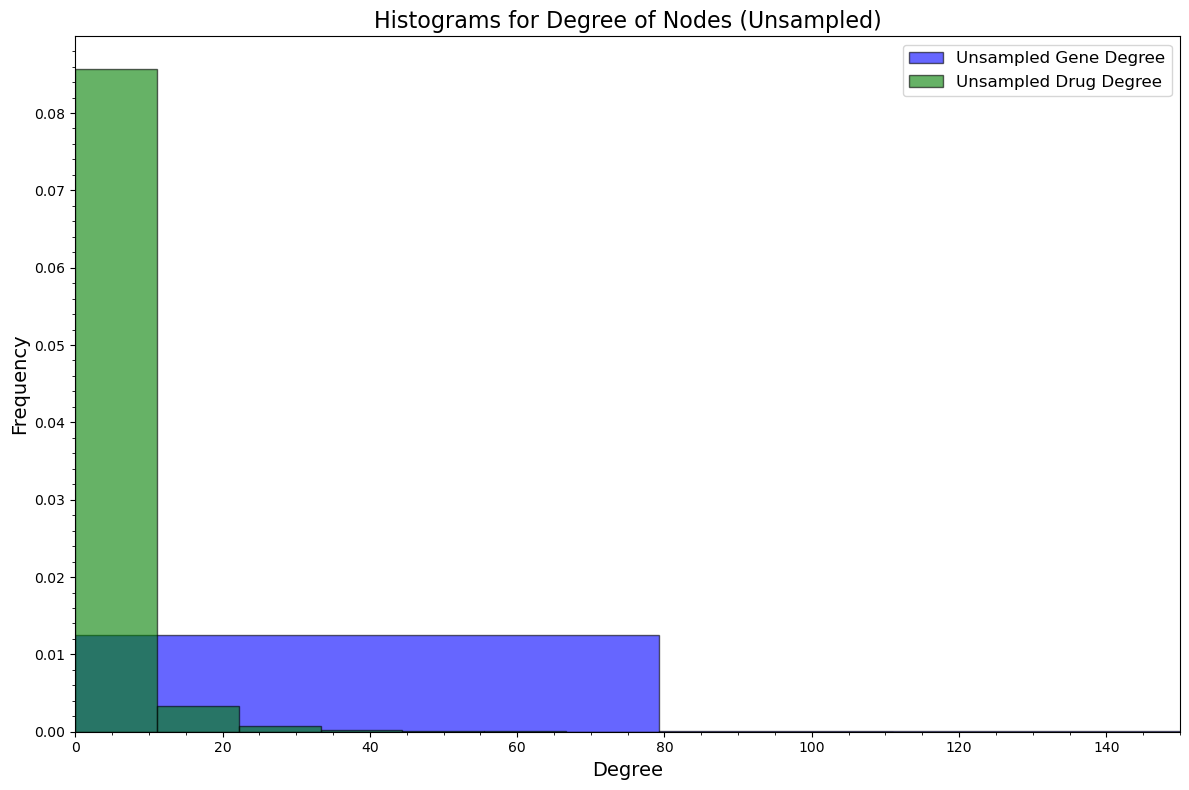

In [156]:
plt.figure(figsize=(12, 8))

# Plot histograms for unsampled gene and drug degrees
plt.hist(unsampled_gene_degree, bins=10, alpha=0.6, label='Unsampled Gene Degree', color='blue', density=True, edgecolor='black')
plt.hist(unsampled_drug_degree, bins=10, alpha=0.6, label='Unsampled Drug Degree', color='green', density=True, edgecolor='black')

# Set the x-axis limit
plt.xlim([0, 150])

# Axis and title settings
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms for Degree of Nodes (Unsampled)', fontsize=16)

# Add legend
plt.legend(loc='upper right', fontsize=12)

# Add minor gridlines for better clarity
#plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

plt.tight_layout()  # Adjusts subplot params for neatness
plt.show()

- Very skewed?

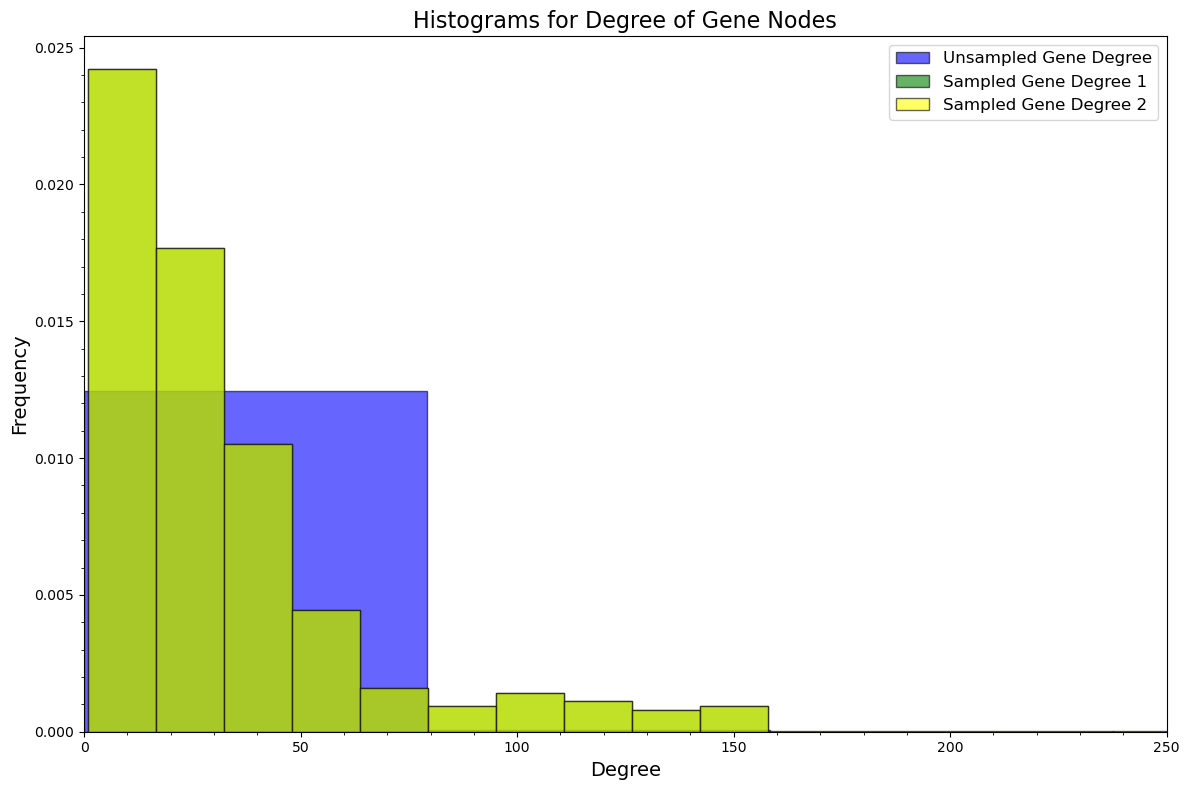

In [153]:
# Plotting the histograms
plt.figure(figsize=(12, 8))

# Histograms
plt.hist(unsampled_gene_degree, bins=10, alpha=0.6, label='Unsampled Gene Degree', color='blue', density=True, edgecolor='black')
plt.hist(sampled_gene_degree_1, bins=10, alpha=0.6, label='Sampled Gene Degree 1', color='green', density=True, edgecolor='black')
plt.hist(sampled_gene_degree_2, bins=10, alpha=0.6, label='Sampled Gene Degree 2', color='yellow', density=True, edgecolor='black')

# Axis and title settings
plt.xlim([0, 250])
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms for Degree of Gene Nodes', fontsize=16)
plt.legend(loc='upper right', fontsize=12)

# Add minor gridlines for better clarity
#plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

plt.tight_layout()  # Adjusts subplot params for neatness
plt.show()

- A more spread-out distribution

- Many real-world networks follow a scale-free property, where the degree distribution follows a power-law, and there are a few nodes with a very high degree and many with a lower degree. The green and yellow histograms seem to capture this property better than the blue one.

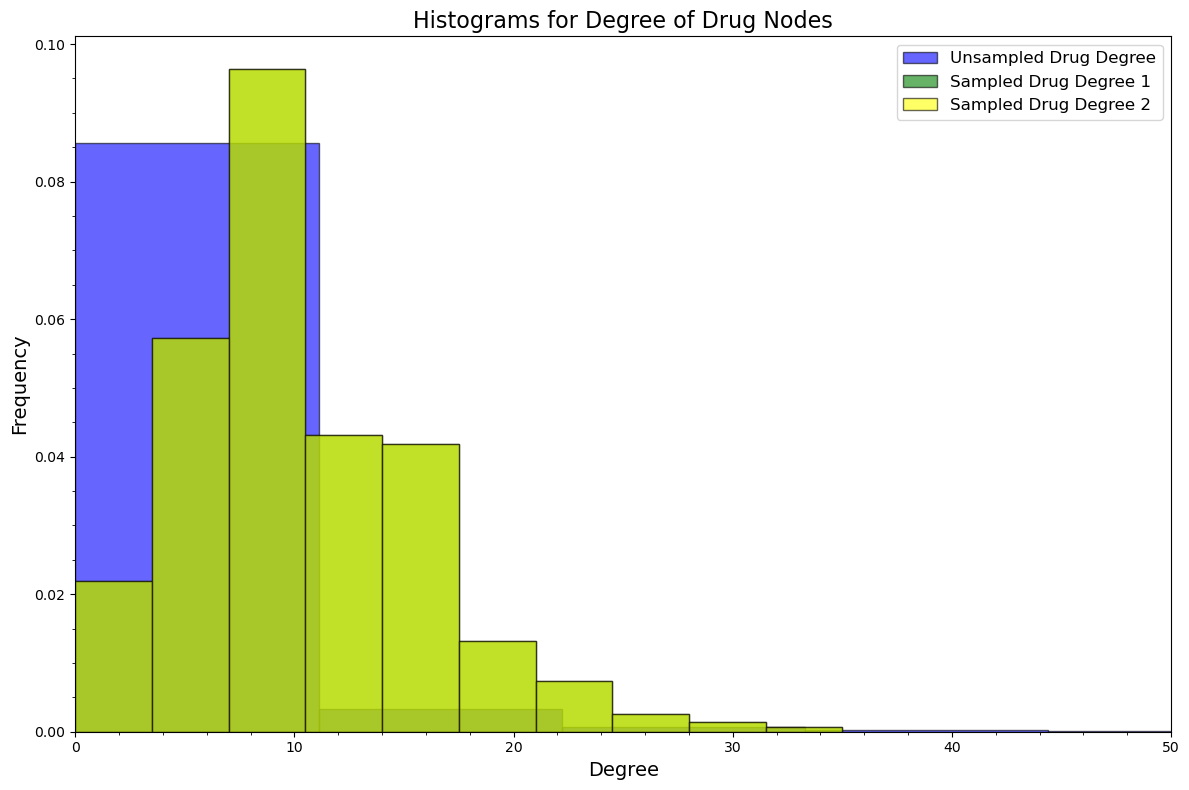

In [154]:
# Plotting the histograms
plt.figure(figsize=(12, 8))

# Histograms
plt.hist(unsampled_drug_degree, bins=10, alpha=0.6, label='Unsampled Drug Degree', color='blue', density=True, edgecolor='black')
plt.hist(sampled_drug_degree_1, bins=10, alpha=0.6, label='Sampled Drug Degree 1', color='green', density=True, edgecolor='black')
plt.hist(sampled_drug_degree_2, bins=10, alpha=0.6, label='Sampled Drug Degree 2', color='yellow', density=True, edgecolor='black')

# Axis and title settings
plt.xlim([0, 50])
plt.xlabel('Degree', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histograms for Degree of Drug Nodes', fontsize=16)
plt.legend(loc='upper right', fontsize=12)

# Add minor gridlines for better clarity
#plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.minorticks_on()

plt.tight_layout()  # Adjusts subplot params for neatness
plt.show()

- The green and yellow histograms may offer a more varied and potentially more realistic view of drug interactions than the blue histogram, which is heavily skewed towards drugs with few interactions.

## Save the preprocessed sets

In [157]:
saved_path_1 = "../data/preprocessed_" + str(min_gene_count_1) + "_" + str(min_drug_count_1) +".tsv"
sampled_interaction_matrix_1.to_csv(saved_path_1, sep='\t', index=False)

saved_path_2 = "../data/preprocessed_" + str(min_gene_count_2) + "_" + str(min_drug_count_2) +".tsv"
sampled_interaction_matrix_1.to_csv(saved_path_2, sep='\t', index=False)